In [59]:
from kaveh.behavioral.oculomotor.session import session
from kaveh.toolbox import find_file
from neo.io import Spike2IO
from matplotlib import pyplot as plt
import numpy as np
import quantities as pq
import csv
import os
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle

In [60]:
def bin_error_dirs(error_dirs):
    '''
    Bin error directions: Bins start from 157.5 and increaments counter-clockwise every 45 degrees => 8 bins, 0 to 7
    '''
    bins = np.arange(-180 + 22.5, 180, 45)
    bin_ind = np.digitize(error_dirs , bins, right=True)
    bin_ind[bin_ind == 8] = 0
    return bin_ind


def get_bin_cs_counts(cs_range, event_times, bin_ind, error_dir_bin_numbers, cs_times):
    '''
    get cs_counts for each bin
    '''
    cs_range = pq.quantity.Quantity(cs_range, 's')
    bin_cs_counts = []

    for ebn in error_dir_bin_numbers:
        bin_times = event_times[bin_ind == ebn]
        cs_count = 0
        if bin_times.size != 0:
            for bt in bin_times:
                cs_count = cs_count + np.count_nonzero(np.where(np.logical_and(cs_times < bt+cs_range, cs_times > bt )))
            cs_count = cs_count*1.0/bin_times.size
            bin_cs_counts.append(cs_count)
        else:
            bin_cs_counts.append(0)
        
    bin_cs_counts = np.array(bin_cs_counts)
#     bin_cs_counts = bin_cs_counts*1.0/np.sum(bin_cs_counts)
    return bin_cs_counts


In [61]:
# These are Buckley files with the following event structure:
# Event 0
# Event 1
# Event 2
# Event 3 : Trial onset
# Event 4 : Primary target presentation in adaptation trials
# Event 5 : Corrective target presentation in adaptation trials
# Event 6 : Divide each trial into its target jumps
# Event 7 : 
buckley_files_correct_events = ['B082107_1340_List.smr', #yes
'B090407_1526_List.smr', # yes
# 'B091208_1545_List.smr', # No done
# 'B091608_1208_List.smr', # No done
'B091707_1414_List.smr', # No done
'B091908_1_1500_List.smr', # No done
'B091908_2_1550_List.smr', # No done
'B093008_1149_List.smr', # No done
'B100308_2_1403_List.smr', # No done
'W091008_1241_List.smr', # No done
'W091208_1337_List.smr', # No done: bimodal cs-on
'W120208_1_1418_List.smr', # No done
'W120508_1_1420_List.smr', # No done
'W120508_2_1628_List.smr'] # No

# f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_25deg/B082107/B082107_1340_List.smr'
# f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_25deg/B110807/B110807_1632_List.smr'

In [62]:
file_to_get_tuning_for = buckley_files_correct_events[0]

In [63]:
with open('../data/neurons_david_data_with_spike_train.csv', 'r') as csv_f:
    reader = csv.reader(csv_f)
    csv_content = np.array(list(reader))
file_names = np.array([fn[0] for fn in csv_content])

for i, fn in enumerate(file_names):
    print('{}: {}'.format(i, fn))

0: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O22/O22_2Adapt_BW5L_FW5LCFRDone.smr
1: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O22/O22_2PreAdaptCFRDone.smr
2: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O13/O13_3_adapt40pct.smr
3: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O13/O13_3_adapt30pct.smr
4: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O13/O13_3_preadapt.smr
5: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O13/O13_3_adapt40pctB.smr
6: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O41/O41_1_FW5L_BW5R_A.smr
7: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O41/O41_1_pre.smr
8: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O29/O29_4Adapt_FW5L_BW5RCFR611sec.smr
9: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O29/O29_4PreAdaptCFRDone.smr
10: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K14/error_direction/K14_1_directiona

In [64]:
f_index =[10, 12, 13, 16, 18, 19, 21, 23, 26, 28, 30, 31, 34, 41, 43, 45, 46, 86, 91, 94, 98]
f_index = f_index + [57, 63, 65, 69, 71, 76, 78]
for i in f_index:
    print('{}: {}'.format(i, file_names[i]))

10: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K14/error_direction/K14_1_directionaltest.smr
12: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K33/error_direction/K33_1dirtest.smr
13: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K33/error_direction/K33_2dirtest.smr
16: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K45/error_direction/K45_1_ErrorDirectionTest.smr
18: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K21/error_direction/K21_2_directionaltest.smr
19: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K69/error_direction/K69_1_DirTuning.smr
21: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K40/error_direction/K40_1_Dirtuning.smr
23: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K16/error_direction/K16_2_directionaltest.smr
26: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Step/S36/error_direction/S36_1_directionalt

In [69]:
import os
bin_cs_counts_for_file = {}
bin_cs_counts_iss_for_file = {}
bin_cs_counts_non_iss_for_file = {}
non_iss_targets_for_file = {}
david_neurons_source = '/mnt/data/temp/kaveh/david_neurons/'
for bf in file_names[f_index]:
#     f_name = find_file(bf, '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt')
    f_name_csv = find_file(os.path.basename(bf)+'.pkl.GMM.CS.csv', david_neurons_source)
    
    f_name = find_file(os.path.basename(bf), '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data')
    f_name_session = find_file(os.path.basename(bf)+'.pkl.session.pkl', david_neurons_source)
    
    print(f_name)

    print(f_name_session)
    print(f_name_csv)
    neo_reader = Spike2IO(filename=f_name)
    neo_data = neo_reader.read()
    data_block = neo_data[0]
    seg = data_block.segments[0]
    events = seg.events
    
     # Load voltage
    t_signal = seg.analogsignals[-1].times
    signal_fs = seg.analogsignals[-1].sampling_rate
    


    # Load cs times from csGUI csv files

    with open(f_name_csv, 'r') as csv_f:
        reader = csv.reader(csv_f)
        csv_content = np.array(list(reader), dtype=np.int64)

    cs_indices = np.squeeze(csv_content[np.where(csv_content[:,1] == 1), 0])
    cs_times = t_signal[cs_indices]

    with open(f_name_session, 'rb') as input:
        try:
            mysess = pickle.load(input, encoding='latin1')
        except TypeError:
            mysess = pickle.load(input)
    # find inra-saccadic target jumps. For each saccade, check if that saccade is accompanied by a simultaneous target jump.
    # If so, it is an intra-saccadic target_jump. 
    # check 25 ms before and after the saccade onset and offset for the target jump onset and offset. if found, the target jump is intra-saccadic

    iss_range = pq.quantity.Quantity(0.025, 's')
    iss_targets = []
    iss_saccades = []
    saccades_with_no_iss_target = []
    for i, (son, soff) in enumerate(zip(mysess.saccade_onset_times, mysess.saccade_offset_times)):
        iss_targets.append(np.where(np.logical_or(np.logical_and(mysess.target_onset_times < son + iss_range, 
                                                                 mysess.target_onset_times > son - iss_range), 
                                                  np.logical_and(mysess.target_offset_times < soff + iss_range, 
                                                                 mysess.target_offset_times > soff - iss_range)))[0])
        if iss_targets[-1].size != 0:
            iss_saccades.append(i)
        if iss_targets[-1].size == 0:
            saccades_with_no_iss_target.append(i)

    iss_targets = np.squeeze(np.array([isst[0] for isst in iss_targets if isst.size != 0]))

    non_iss_target_jumps = np.setdiff1d(np.arange(mysess.target_onset_times.size), iss_targets)

    mysess._calc_error_vectors()

    error_dir_bin_ind = mysess.bin_error_dirs()
    error_mag_bin_ind = mysess.bin_error_mags()

    iss_saccades = np.array(iss_saccades)

    iss_saccades_bin_ind = bin_error_dirs(mysess.error_dir[iss_saccades])
    non_iss_saccades_bin_ind = bin_error_dirs(mysess.error_dir[saccades_with_no_iss_target])

    error_dir_bin_numbers = np.unique(error_dir_bin_ind)
    error_mag_bin_numbers = np.unique(error_mag_bin_ind)

    bin_cs_counts_for_file[bf] = get_bin_cs_counts(0.200, mysess.saccade_offset_times, error_dir_bin_ind, error_dir_bin_numbers, cs_times)
    bin_cs_counts_iss_for_file[bf] = get_bin_cs_counts(0.200, mysess.saccade_offset_times[iss_saccades], iss_saccades_bin_ind, error_dir_bin_numbers, cs_times)
    bin_cs_counts_non_iss_for_file[bf] = get_bin_cs_counts(0.200, mysess.saccade_offset_times[saccades_with_no_iss_target], non_iss_saccades_bin_ind, error_dir_bin_numbers, cs_times)

    print(bin_cs_counts_for_file[bf])
    print(bin_cs_counts_iss_for_file[bf])
    print(bin_cs_counts_non_iss_for_file[bf])
    
       

    # calculate target vectors (target_offset_position - target_onset_position)
    ton_VT = np.squeeze(mysess.VT[mysess.target_onsets[non_iss_target_jumps]])
    toff_VT = np.squeeze(mysess.VT[mysess.target_offsets[non_iss_target_jumps]])

    ton_HT = np.squeeze(mysess.HT[mysess.target_onsets[non_iss_target_jumps]])
    toff_HT = np.squeeze(mysess.HT[mysess.target_offsets[non_iss_target_jumps]])

    target_jump_H = toff_HT - ton_HT
    target_jump_V = toff_VT - ton_VT

    target_jump_dir = np.arctan2(target_jump_V, target_jump_H) * 180 / np.pi

    target_jump_mag = np.linalg.norm(np.vstack((target_jump_H, target_jump_V)), axis = 0)

    bin_ind = np.digitize(target_jump_dir, bins = np.arange(-180 + 22.5, 180, 45))

    bin_ind[bin_ind == 8] = 0

    non_iss_targets_for_file[bf] = get_bin_cs_counts(0.160, mysess.target_offset_times[non_iss_target_jumps],
                                                bin_ind, np.unique(bin_ind), cs_times)

/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K14/error_direction/K14_1_directionaltest.smr
/mnt/data/temp/kaveh/david_neurons/K14/error_direction/K14_1_directionaltest.smr.pkl.session.pkl
/mnt/data/temp/kaveh/david_neurons/K14/error_direction/K14_1_directionaltest.smr.pkl.GMM.CS.csv
[0.31130573 0.41647597 0.2915601  0.128125   0.08128079 0.11950791
 0.14937759 0.23042506]
[0.3699115  0.44407895 0.35684647 0.11888112 0.07142857 0.07901907
 0.10789474 0.17111111]
[0.2633864  0.35338346 0.18666667 0.20588235 0.21428571 0.19306931
 0.19533528 0.24537815]
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K33/error_direction/K33_1dirtest.smr
/mnt/data/temp/kaveh/david_neurons/K33/error_direction/K33_1dirtest.smr.pkl.session.pkl
/mnt/data/temp/kaveh/david_neurons/K33/error_direction/K33_1dirtest.smr.pkl.GMM.CS.csv
[0.12093023 0.25365854 0.5        0.2826087  0.15178571 0.09183673
 0.02352941 0.05882353]
[0.11111111 0.27027027 0.57692308 0.33870968 0.12307692

[0.1092437  0.12987013 0.125      0.15625    0.14634146 0.25
 0.23076923 0.14201183]
[0.14285714 0.22727273 0.07407407 0.13793103 0.14285714 0.25806452
 0.26666667 0.47058824]
[0.08571429 0.         0.23076923 0.33333333 0.16666667 0.22222222
 0.21311475 0.10526316]
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Wyatt/W120208_1/W120208_1_1418_List.smr
/mnt/data/temp/kaveh/david_neurons/W120208_1/W120208_1_1418_List.smr.pkl.session.pkl
/mnt/data/temp/kaveh/david_neurons/W120208_1/W120208_1_1418_List.smr.pkl.GMM.CS.csv
[0.04545455 0.07526882 0.2173913  0.28947368 0.17647059 0.11904762
 0.10204082 0.075     ]
[0.03030303 0.12195122 0.11111111 0.25581395 0.15384615 0.13636364
 0.1        0.1       ]
[0.09090909 0.03846154 0.23976608 0.30985915 0.21212121 0.1
 0.10526316 0.        ]
/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_12deg/B091908_2/B091908_2_1550_List.smr
/mnt/data/temp/kaveh/david_neurons/B091908_2/B091908_2_1550_List.smr.pkl.session.pkl
/mnt/da

In [ ]:
bins = np.arange(-180 + 22.5, 180, 45)
print(bins)

In [70]:
tunings_all = []
for val in bin_cs_counts_for_file.values():
    print(val)
    print(np.argmax(val))
    zero_idx = np.argmax(val)
    tunings_all.append(np.roll(val, 3-zero_idx , axis=0))
    
tunings_iss = []
for val in bin_cs_counts_iss_for_file.values():
    print(val)
    print(np.argmax(val))
    zero_idx = np.argmax(val)
    tunings_iss.append(np.roll(val, 3-zero_idx , axis=0))
    
tunings_non_iss = []
for val in bin_cs_counts_non_iss_for_file.values():
    print(val)
    print(np.argmax(val))
    zero_idx = np.argmax(val)
    tunings_non_iss.append(np.roll(val, 3-zero_idx , axis=0))
#     stim_tunings.append(np.roll(csv_content, 3-zero_idx , axis=1)[3,:])

tunings_target_non_iss = []
for val in non_iss_targets_for_file.values():
    print(val)
    print(np.argmax(val))
    zero_idx = np.argmax(val)
    tunings_target_non_iss.append(np.roll(val, 3-zero_idx , axis=0))

[0.31130573 0.41647597 0.2915601  0.128125   0.08128079 0.11950791
 0.14937759 0.23042506]
1
[0.22516556 0.29       0.23076923 0.07894737 0.09174312 0.07246377
 0.04347826 0.08490566]
1
[0.04210526 0.12096774 0.20408163 0.27906977 0.16666667 0.27027027
 0.12121212 0.03921569]
3
[0.11727617 0.0483871  0.03743316 0.06422018 0.03108808 0.11428571
 0.29680365 0.23861852]
6
[0.1092437  0.12987013 0.125      0.15625    0.14634146 0.25
 0.23076923 0.14201183]
5
[0.3006135  0.14864865 0.06796117 0.02       0.         0.01538462
 0.01538462 0.1369863 ]
0
[0.29545455 0.16666667 0.06578947 0.10526316 0.04347826 0.13913043
 0.2278481  0.43902439]
7
[0.10594315 0.14210526 0.06923077 0.02890173 0.06271777 0.03960396
 0.03319502 0.06940874]
1
[0.33502538 0.17821782 0.12295082 0.06918239 0.13103448 0.15277778
 0.38888889 0.32061069]
6
[0.37735849 0.28333333 0.08       0.08695652 0.06097561 0.04347826
 0.1884058  0.20454545]
0
[0.18333333 0.16666667 0.1369863  0.13461538 0.11578947 0.14102564
 0.28125 

In [71]:
# tunings_all = np.array(tunings_all)
# print(tunings_all.shape)

tunings_iss = np.array(tunings_iss)
print(tunings_iss.shape)

tunings_non_iss = np.array(tunings_non_iss)
print(tunings_non_iss.shape)

tunings_target_non_iss = np.array(tunings_target_non_iss)
print(tunings_target_non_iss.shape)

(28, 8)
(28, 8)
(28, 8)


In [72]:
mean_non_iss = np.mean(tunings_non_iss, axis = 0)
sd_non_iss = np.std(tunings_non_iss, axis = 0)/np.sqrt(tunings_non_iss.shape[0]-1)

mean_iss = np.mean(tunings_iss, axis = 0)
sd_iss = np.std(tunings_iss, axis = 0)/np.sqrt(tunings_iss.shape[0]-1)

mean_target_non_iss = np.mean(tunings_target_non_iss, axis = 0)
sd_target_non_iss = np.std(tunings_target_non_iss, axis = 0)/np.sqrt(tunings_target_non_iss.shape[0]-1)


In [73]:
%matplotlib notebook


<IPython.core.display.Javascript object>


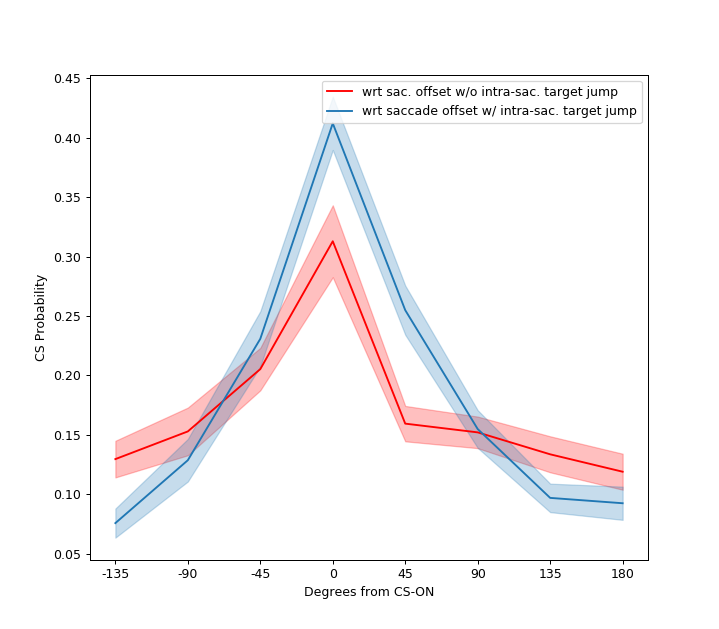

In [56]:
x = [-135, -90, -45, 0, 45, 90, 135, 180]
plt.figure(figsize=(8,7))
l = plt.plot(x, mean_non_iss, 'r')
plt.fill_between(x, mean_non_iss - sd_non_iss, mean_non_iss + sd_non_iss, color=l[0].get_color(), alpha=0.25)

l = plt.plot(x, mean_iss)
plt.fill_between(x, mean_iss - sd_iss, mean_iss + sd_iss, color=l[0].get_color(), alpha=0.25)
plt.xticks(x,x)

plt.xlabel('Degrees from CS-ON')
plt.ylabel('CS Probability')
plt.legend(['wrt sac. offset w/o intra-sac. target jump','wrt saccade offset w/ intra-sac. target jump'])

<IPython.core.display.Javascript object>


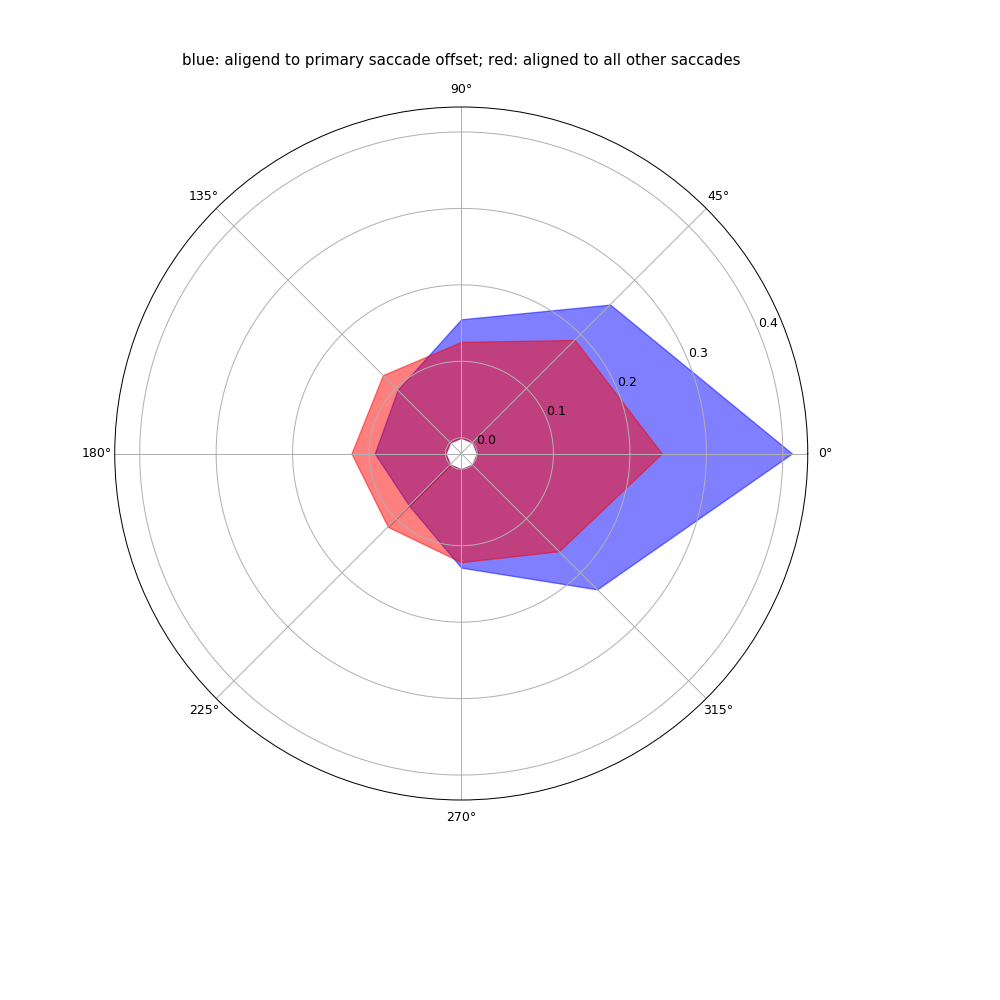

Text(0.5,1.05,u'blue: aligend to primary saccade offset; red: aligned to all other saccades')

In [74]:
theta = np.array([-135, -90, -45, 0, 45, 90, 135, 180])*np.pi/180
plt.figure(figsize=(10,10))
plt.polar(np.hstack((theta, theta[0])), np.hstack((mean_iss , mean_iss[0])), alpha = 0.02,color = 'b' )
plt.fill_between( np.hstack((theta, theta[0])),0, np.hstack((mean_iss , mean_iss[0])), alpha = 0.5, color = 'b')

plt.polar(np.hstack((theta, theta[0])), np.hstack((mean_target_non_iss , mean_target_non_iss[0])), alpha = 0.02,color = 'r' )
plt.fill_between(np.hstack((theta, theta[0])),0, np.hstack((mean_target_non_iss , mean_target_non_iss[0])), alpha = 0.5, color = 'r')
plt.title('blue: aligend to primary saccade offset; red: aligned to all other saccades')

In [75]:
plt.savefig('../data/plots/Saliency_stuff/cs_tuning_with_primary_vs_target_polar.png')
plt.savefig('../data/plots/Saliency_stuff/cs_tuning_with_primary_vs_target_polar.svg')


<IPython.core.display.Javascript object>


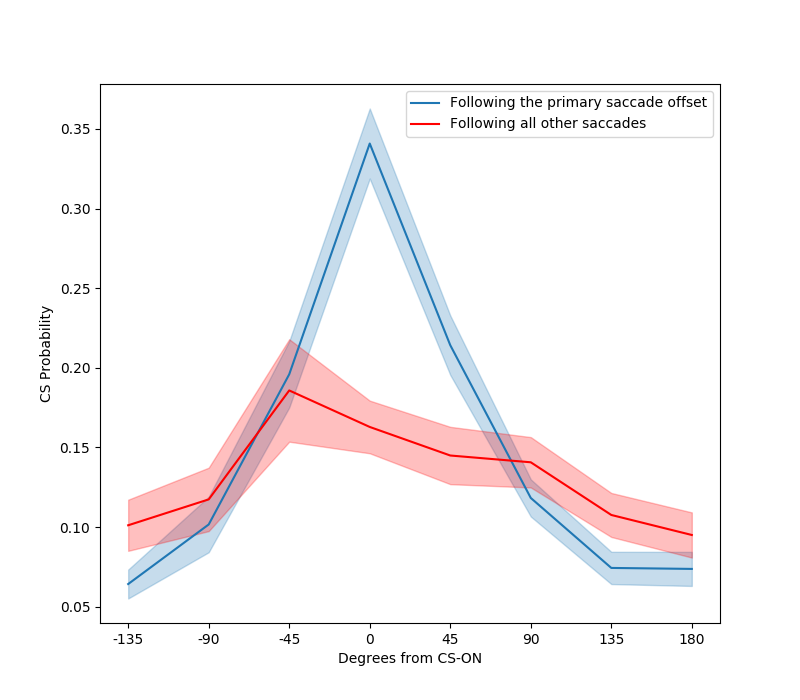

In [32]:
x = [-135, -90, -45, 0, 45, 90, 135, 180]
plt.figure(figsize=(8,7))


l = plt.plot(x, mean_iss)
plt.fill_between(x, mean_iss - sd_iss, mean_iss + sd_iss, color=l[0].get_color(), alpha=0.25)

l = plt.plot(x, mean_non_iss, 'r')
plt.fill_between(x, mean_non_iss - sd_non_iss, mean_non_iss + sd_non_iss, color=l[0].get_color(), alpha=0.25)
plt.xticks(x,x)

plt.xlabel('Degrees from CS-ON')
plt.ylabel('CS Probability')
plt.legend(['Following the primary saccade offset', 'Following all other saccades'])

In [21]:
plt.title('n = 30')

Text(0.5,1,u'n = 30')

In [18]:
plt.savefig('../data/plots/Saliency_stuff/tuning_with_respect_to_sac_endpoint_GMM_cs_30_neurons_for_sfn_correct_alignment.png')
plt.savefig('../data/plots/Saliency_stuff/tuning_with_respect_to_sac_endpoint_GMM_cs_30_neurons_for_sfn_correct_alignment.svg')

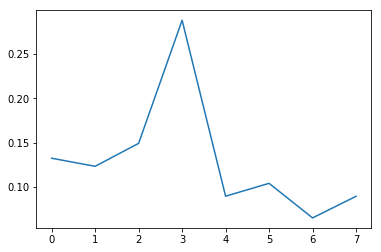

In [39]:
plt.figure()
plt.plot(np.mean(tunings_non_iss, axis = 0))

In [22]:
print(val)
print(np.roll(val, 2, axis=0))

[0.11940299 0.05263158 0.1        0.15151515 0.22580645 0.41666667
 0.25       0.12264151]
[0.25       0.12264151 0.11940299 0.05263158 0.1        0.15151515
 0.22580645 0.41666667]


In [6]:
count = 0
_sum = 0
for key in bin_cs_counts_for_file:
    count += 1
    _sum += bin_cs_counts_for_file[key]

array([0.11584062, 0.0948156 , 0.11943885, 0.15345987, 0.1575367 ,
       0.18213765, 0.14851073, 0.10212838])